In [3]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
#plt.rcParams.update({   "text.usetex": True,})
import scipy.interpolate

In [35]:
#kvec = np.logspace(1e-3,1e1,20)#
kvec = [1e-1,1,1e1]
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
mv_test = 0.3 
H0 = 67 / (3*1e5) # i 1/Mpc

cosmo_dict ={'H0':70,  'Omega_cdm':0.3, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }

cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()

pts = cosmo.get_perturbations()['scalar']
print(bg.keys())
pts0=pts[0]
pts_sidst=pts[-1]
print(f"{pts0.keys()=}")
#print( cosmo.Hubble(0))
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]

a0  =1e-9
mv = mv_test * 1e-6

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
pts0.keys()=dict_keys(['tau [Mpc]', 'a', 'delta_g', 'theta_g', 'shear_g', 'pol0_g', 'pol1_g', 'pol2_g', 'delta_b', 'theta_b', 'psi', 'phi', 'delta_ur', 'theta_ur', 'shear_ur', 'delta_cdm', 'theta_cdm', 'delta_ncdm[0]', 'theta_ncdm[0]', 'shear_ncdm[0]', 'cs2_ncdm[0]'])


# X



In [171]:
x = 10
k_ind = 1
k = kvec[k_ind]

T_ini = x / k

# Alle ligningerne

1e-09 1.0002559621863683
0.9999487505865133


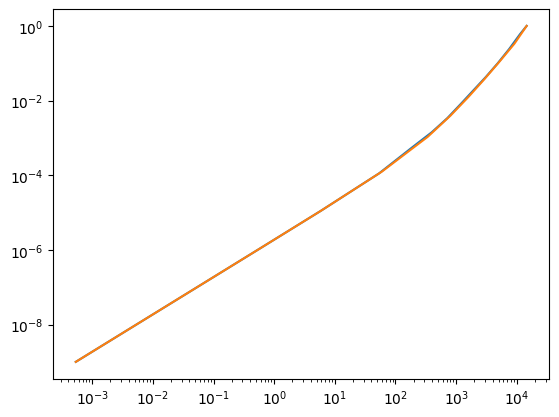

In [172]:
# udregner Hubbleparameteren

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

# udregnger tau 

def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

# temperatur

def Tv(a):
    return T0 / a # in MeV

# lydhastighed

def cs(a,mv):
    return 2.680 * Tv(a) / mv

# udregn a
def a_solve(tau,y):
    a = y[0]
    a_dt = a * a * H(a)
    return [a_dt]




tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
tau = sol_tau.y[0]


sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
a_tau = sol_a.t
a = sol_a.y[0]

print(a[0],a[-1])
a_interp = scipy.interpolate.interp1d(a_tau,a)
print(a_interp(14550))

plt.loglog(tau,a_interp(tau))
plt.loglog(a_tau,a)



In [173]:
delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
# = np.interp(T_ini,tau_class,delta_class)
#np.interp(T_ini,)
delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]


a_class = pts[k_ind]["a"]

delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)




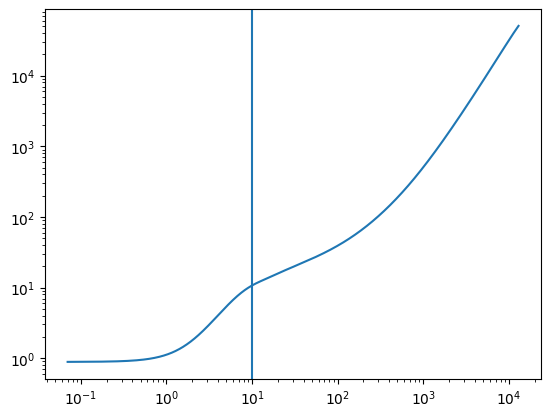

In [174]:
plt.loglog(tau_class,-delta_class)
plt.axvline(T_ini)

# Metode 1 - først relevant når det med tau_init er fikset

In [175]:

def cdm_solve(t,y):    
    delta     = y[0]
    theta     = y[1]
    #print(delta,theta)
    a = a_interp(t)
    #print(a)
    d_delta   = - theta
    nabla2phi = (3/2) * H(a)*H(a) * Omega_M * delta
    #print(f"{a=}",f"{H(a)=}",f"{nabla2phi=}")
    d_theta   = -  H(a) * theta - nabla2phi
    #[d_delta,d_theta]
    return [d_delta,d_theta]
    
y0 = [float(delta_init), float(theta_init)]
#print(y0)
t_span = [tau[0],tau[-1]]
#print(t_span)
sol_cdm = sc.solve_ivp(cdm_solve,
                       t_span= t_span,
                       y0 = y0)
tau_e = sol_cdm.t
delta_cdm = sol_cdm.y[0]

delta_interp = scipy.interpolate.interp1d(tau_e,delta_cdm)

plt.loglog(tau_e,-delta_cdm)


/tmp/ipykernel_320/3723002861.py:8: RuntimeWarning: overflow encountered in double_scalars
  nabla2phi = (3/2) * H(a)*H(a) * Omega_M * delta


Error in callback <function _draw_all_if_interactive at 0x7f0ac0e70f70> (for post_execute):


OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

<Figure size 640x480 with 1 Axes>

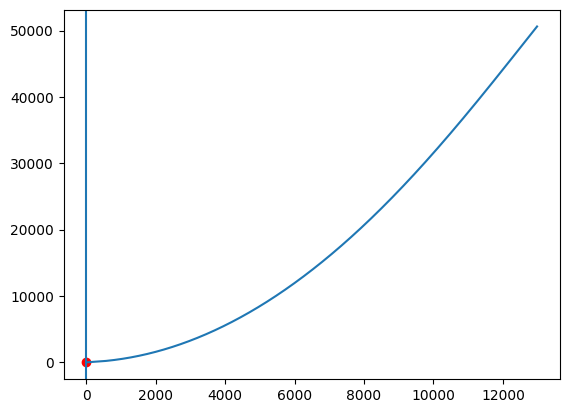

In [176]:
"""
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta   = - a* H(a) * theta - nabla2phi"""


delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)
# = np.interp(T_ini,tau_class,delta_class)
#np.interp(T_ini,)
delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]


a_class = pts[k_ind]["a"]

delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)

plt.plot(tau_class,-delta_class)
plt.axvline(T_ini)
plt.scatter(T_ini,delta_init,c="red")

/tmp/ipykernel_320/1513307802.py:17: RuntimeWarning: overflow encountered in double_scalars
  nabla2phi = (3/2) * H(a)*H(a) * Omega_M * delta
/tmp/ipykernel_320/1513307802.py:18: RuntimeWarning: overflow encountered in double_scalars
  d_theta   = -  H(a) * theta - nabla2phi
/tmp/ipykernel_320/1513307802.py:18: RuntimeWarning: invalid value encountered in double_scalars
  d_theta   = -  H(a) * theta - nabla2phi


Text(0.5, 0, 'a')

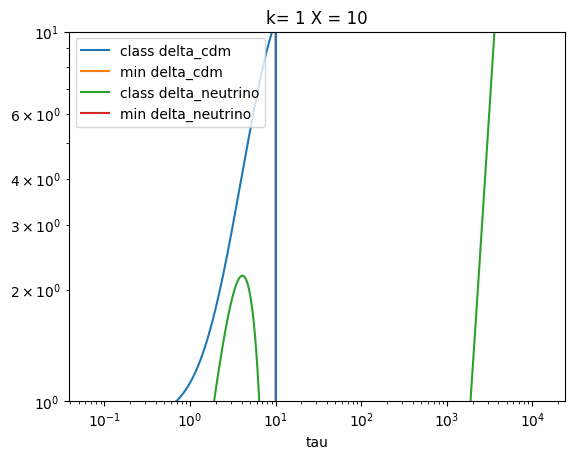

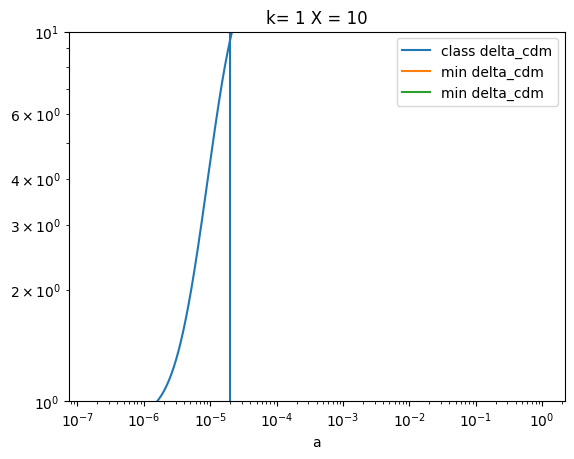

In [182]:
"""'

def cdm_solve(t,y):    
    delta     = y[0]
    theta     = y[1]
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta   = - a* H(a) * theta - nabla2phi  
    return [d_delta,d_theta]"""

def cdm_solve(t,y):    
    delta     = y[0]
    theta     = y[1]
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H(a)*H(a) * Omega_M * delta
    d_theta   = -  H(a) * theta - nabla2phi
    return [d_delta,d_theta]
    
    
y0 = [delta_init, theta_init]

t_span = [T_ini,tau[-1]]

sol_cdm = sc.solve_ivp(cdm_solve,
                       t_span= t_span,
                       y0 = y0)
tau_e = sol_cdm.t
delta_cdm = sol_cdm.y[0]


delta_interp = scipy.interpolate.interp1d(tau_e,delta_cdm)
def neutrino_solve(t,y,k,mv):    
    delta     = y[0]
    theta     = y[1]
    a = a_interp(t)
    delta_cdm = delta_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H(a)**2 * Omega_M * delta_cdm
    
    d_theta   = - H(a) * theta - nabla2phi + k*k * cs(a,mv)**2 * delta
    #print([d_delta,d_theta])
    return [d_delta,d_theta]

y0_neutrino = [delta_neutrino_init,theta_neutrino_init]

sol_neutrino = sc.solve_ivp(neutrino_solve,t_span = t_span,y0 = y0_neutrino,args=(k,mv))
neutrino = sol_neutrino.y[0]
tau_neu = sol_neutrino.t


plt.loglog(tau_class,-delta_class,label="class delta_cdm")
plt.loglog((tau_e),-delta_cdm,label="min delta_cdm")

plt.loglog(tau_class,-delta_neutrino_class,label="class delta_neutrino")
plt.loglog((tau_neu),-neutrino,label="min delta_neutrino")
plt.legend()
plt.axvline(T_ini)
plt.title("k= %s X = %s" %(k,x))
plt.xlabel("tau")


plt.figure(132)

plt.loglog(a_class,-delta_class,label="class delta_cdm")
plt.loglog(a_interp(tau_e),-delta_cdm,label="min delta_cdm")
plt.loglog(a_interp(tau_e),delta_cdm,label="min delta_cdm")
plt.legend()
plt.axvline(a_interp(T_ini))
plt.title("k= %s X = %s" %(k,x))
plt.xlabel("a")




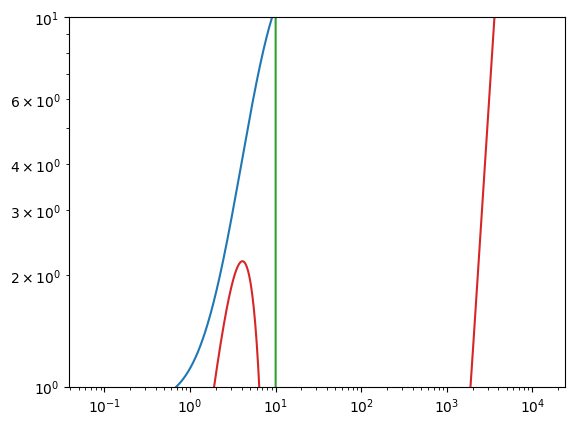

In [178]:

plt.loglog(tau_class,-delta_class)
plt.loglog((tau_e),-delta_cdm)
plt.loglog((tau_neu), -neutrino)
plt.loglog(tau_class,-delta_neutrino_class)


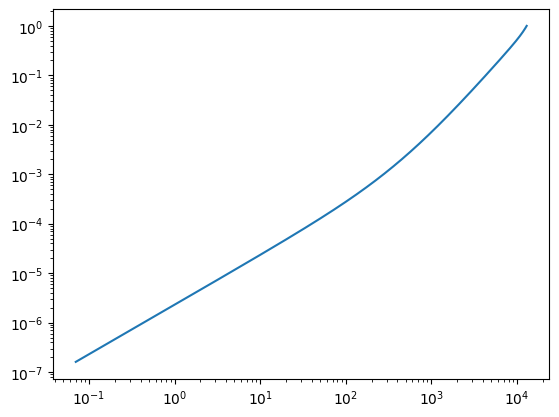

In [73]:
plt.loglog(pts[k]["tau [Mpc]"],pts[k]["a"])

In [93]:
# udregner Hubbleparameteren

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

# udregnger tau 

def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

# temperatur

def Tv(a):
    return T0 / a # in MeV

# lydhastighed

def cs(a,mv):
    return 2.680 * Tv(a) / mv

# udregn a
def a_solve(tau,y):
    a = y[0]
    a_dt = a * a * H(a)
    return [a_dt]




tau_init = T_ini


sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
tau = sol_tau.y[0]


sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
a_tau = sol_a.t
a = sol_a.y[0]

print(a[0],a[-1])
a_interp = scipy.interpolate.interp1d(a_tau,a)
print(a_interp(14550))





1e-09 1.000271396776781
0.9987244633213336
